In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [2]:
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session

import LineWorlds # Local module with code for 2D maps where
                  # the primitive objects are line segments.
const L = LineWorlds
const Geo = L.Geometry;

In [3]:
# Load function to construct a "hotel" map with a given number
# of identical rooms.
includet("01/hotel_env.jl")

# Construct a hotel environment with 4 rooms.
(walls, bounding_box) = construct_hotel_env(4);
rooms = get_hotel_rooms(4);

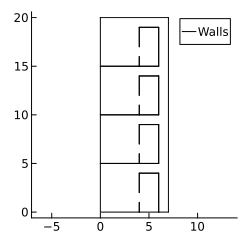

In [4]:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, label="Walls")

In [5]:
function rect_to_segs((b, l), (w, h))
    return L.Segment.(Vector{Float64}[
        [b, l, b + w, l],
        [b + w, l, b + w, l + h],
        [b + w, l + h, b, l + h],
        [b, l + h, b, l]
    ])
end
room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in rooms]...)

square_rooms = _rooms(4)
sq_room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in square_rooms]...)

16-element Vector{LineWorlds.Geometry.Segment}:
 LineWorlds.Geometry.Segment([0.0, 0.0], [4.0, 0.0])
 LineWorlds.Geometry.Segment([4.0, 0.0], [4.0, 5.0])
 LineWorlds.Geometry.Segment([4.0, 5.0], [0.0, 5.0])
 LineWorlds.Geometry.Segment([0.0, 5.0], [0.0, 0.0])
 LineWorlds.Geometry.Segment([0.0, 5.0], [4.0, 5.0])
 LineWorlds.Geometry.Segment([4.0, 5.0], [4.0, 10.0])
 LineWorlds.Geometry.Segment([4.0, 10.0], [0.0, 10.0])
 LineWorlds.Geometry.Segment([0.0, 10.0], [0.0, 5.0])
 LineWorlds.Geometry.Segment([0.0, 10.0], [4.0, 10.0])
 LineWorlds.Geometry.Segment([4.0, 10.0], [4.0, 15.0])
 LineWorlds.Geometry.Segment([4.0, 15.0], [0.0, 15.0])
 LineWorlds.Geometry.Segment([0.0, 15.0], [0.0, 10.0])
 LineWorlds.Geometry.Segment([0.0, 15.0], [4.0, 15.0])
 LineWorlds.Geometry.Segment([4.0, 15.0], [4.0, 20.0])
 LineWorlds.Geometry.Segment([4.0, 20.0], [0.0, 20.0])
 LineWorlds.Geometry.Segment([0.0, 20.0], [0.0, 15.0])

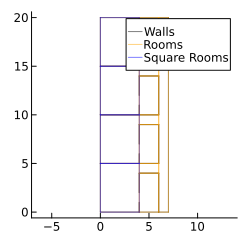

In [6]:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, linealpha=0.5, label="Walls")
plot!(room_segs, c=:orange, linealpha=0.5, label="Rooms")
plot!(sq_room_segs, c=:blue, linealpha=0.5, label="Square Rooms")

In [7]:
#=

=#

In [8]:
using Gen

In [9]:
### Ground truth world model parameters ###
PARAMS = (;
    map = walls,
    p_kidnapped = 0.,
    bounding_box = bounding_box,
    all_rooms = rooms,
    viable_rooms=square_rooms,
    target_pose_relative_to_room=[1., 1.],
    step = (; Δ = 0.25, σ = 0.005 ), # step model arguments
    obs = (; fov = 2π, n_rays = 80,  # obs model arguments
        orientation=π/2,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

In [10]:
@dist labeled_categorical(labels, probs) = labels[categorical(probs)]

Gen.CompiledDistWithArgs{Any}(Gen.WithLabelArg{Any, Int64}(Gen.Categorical()), 2, Bool[0, 1], (Gen.SimpleArg{Any}(1), Gen.SimpleArg{Any}(2)))

In [11]:
### Initial state distribution ###

mvuniform = L.ProductDistribution(uniform);
@gen function world_initial_model(params)

    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    # Which room is the target object in?
    target_room ~ labeled_categorical(params.viable_rooms, [1/length(params.viable_rooms) for _ in params.viable_rooms])
    
    # POMDP state: agent position; which room the target object is in
    return (; pos, target_room)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#314", Bool[0], false)

In [450]:
includet("../../notebooks_clean/KidnappedRobot/motion_model_utils.jl")

@gen function motion_model(prev_pos, action, params)
    # Move the agent up/down/left/right by params.step.Δ units.
    np = det_next_pos(prev_pos, action, params.step.Δ)
        
    # Have an affordance in the model for the agent to randomly
    # re-locate to a new position.
    is_kidnapped ~ bernoulli(params.p_kidnapped)

    if !is_kidnapped
        # In normal operation, the agent moves to `np`, plus
        # a bit of stochastic noise.
        pos ~ broadcasted_normal(np, params.step.σ)

        # If `np` plus the noise
        # would have the agent collide with a wall, the agent
        # halts preemptively.
        next_pos = handle_wall_intersection(prev_pos, pos, params.map)

    else
        # If the robot was kidnapped, it could appear anywhere.
        # {*} syntax inlines the random choices (here, `:pos`) from the
        # `uniform_agent_pos` generative function into this one.
        next_pos = {*} ~ uniform_agent_pos(params)
    end

    return next_pos
end

# Motion model accepts the previous world state (the agent's previous position)
# and an action in [:up, :down, :left, :right, :stay]
@gen function world_step_model(prev_state, action, params)
    (prev_pos, target_room) = prev_state
    next_pos = {*} ~ motion_model(prev_pos, action, params)
    return (next_pos, target_room)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#8123", Bool[0, 0, 0], false)

In [451]:
### Observation model ###

# Load: `get_sensor_args`; `sensordist_2dp3`.
includet("../../notebooks_clean/KidnappedRobot/sensor_model_utils.jl")

function get_sensor_args(pos, params, segs)
    p = L.Pose(pos, params.obs.orientation)
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], segs; num_a=params.obs.n_rays, zmax)
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]

    return (ỹ, s_noise, outlier, outlier_vol)
end

# This observation model generates noisy LIDAR measurements
# from the agent to the surrounding walls.
# See the visuals below.
@gen function world_sensor_model(state, params)
    (pos, target_room) = state

    # Place the target object in the target room,
    # and get the overall collection of line segments making up the environment
    # (containing both the environment "map" [walls], and the target object).
    target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
    env_segments = vcat(params.map, target_object_segments)
    sensor_args = get_sensor_args(pos, params, env_segments)

    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#8124", Bool[0, 0], false)

In [452]:
import GenPOMDPs

In [453]:
# POMDP of this environment
world_pomdp = GenPOMDPs.GenPOMDP(
    world_initial_model,     # INIT   : params                      ⇝ state
    world_step_model,        # STEP   : prev_state, action, params  ⇝ state
    world_sensor_model,      # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#314", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#8123", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#8124", Bool[0, 0], false), var"#669#670"())

### Agent's mental model of the environment

In [456]:
# Import immutable dictionary data structure.
import FunctionalCollections: PersistentArrayMap, assoc

In [457]:
@gen function mental_initial_model(params)
    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    room_placements = PersistentArrayMap{Any, Any}()
    
    # POMDP state: agent position; which room the target object is in;
    # whether we sampled a new room placement this step.
    # For now, we assume we always spawn in a room where the object is _not_, so we will be
    # able to localize without knowing where the object is.
    return (pos, room_placements)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#8125", Bool[0], false)

In [458]:
@gen function extend_placements(pos, room_placements, params)
    room = room_containing(pos, params)
    if haskey(room_placements, room) || !(room in params.viable_rooms)
        return (room_placements, false)
    end
    println("room should be added...")

    p_in_room = (1 - params.p_no_object) / (length(params.viable_rooms) - length(room_placements))
    object_is_in_room ~ bernoulli(p_in_room)

    newmap = assoc(room_placements, room, object_is_in_room)
    println("object_is_in_room: ", object_is_in_room)
    println("newmap: ", newmap)
    
    return (newmap, true)
end

@gen function mental_step_model(state, action, params)
    (pos, room_placements) = state

    next_pos = {*} ~ motion_model(pos, action, params)
    extended_placements ~ extend_placements(next_pos, room_placements, params)
    (new_room_placements, new_placement_decided) = extended_placements
    
    return (next_pos, new_room_placements)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#8127", Bool[0, 0, 0], false)

In [527]:
@gen function mental_sensor_model(state, params)
    (pos, room_placements) = state

    if target_object_placed(room_placements)
        target_room = get_target_room(room_placements)
        target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
        env_segments = vcat(params.map, target_object_segments)
        println("adding target object segments")
    else
        env_segments = params.map
    end

    sensor_args = get_sensor_args(pos, params, env_segments)
    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#8761", Bool[0, 0], false)

In [528]:
mental_pomdp = GenPOMDPs.GenPOMDP(
    mental_initial_model,    # INIT   : params                      ⇝ state
    mental_step_model,       # STEP   : prev_state, action, params  ⇝ state
    mental_sensor_model,     # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#8125", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#8127", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#8761", Bool[0, 0], false), var"#781#782"())

In [530]:
# Code for the agent's reasoning about room room_placements

target_object_placed(room_placements) = any(values(room_placements))
get_target_room(room_placements) = findfirst(room_placements)

function in_room(pos, room)
    (xmin, ymin), (w, h) = room
    xmax, ymax = xmin + w, ymin + h
    x, y = pos
    return xmin <= x <= xmax && ymin <= y <= ymax
end
function room_containing(pos, params)
    for room in params.all_rooms
        if in_room(pos, room)
            return room
        end
    end
    error("Position $pos is not in any room")
end
function room_center(room)
    (xmin, ymin), (w, h) = room
    return (xmin + w/2, ymin + h/2)
end
function taxi_dist_to_room_center(pos, room)
    (x, y) = pos
    (cx, cy) = room_center(room)
    return abs(x - cx) + abs(y - cy)
end
function nearest_unexplored_room(pos, params, room_placements)
    nearest_room = nothing
    nearest_dist = Inf
    for room in params.viable_rooms
        if haskey(room_placements, room)
            continue
        end
        dist = taxi_dist_to_room_center(pos, room)
        if dist < nearest_dist
            nearest_room = room
            nearest_dist = dist
        end
    end
    return nearest_room
end

function object_pos(room_placements, target_relative_to_pos)
    target_room = get_target_room(room_placements)
    if isnothing(target_room)
        return nothing
    end
    (xmin, ymin), (w, h) = target_room
    (x, y) = target_relative_to_pos
    return (xmin + x, ymin + y)
end

object_pos (generic function with 1 method)

In [531]:
extend_placements

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##extend_placements#8126", Bool[0, 0, 0], false)

In [532]:
# Code for getting the segments corresponding to the target object
function segments_for_object_in(target_room, target_pose_relative_to_room; side_length=.8)
    (l, b) = target_room.bl
    (δx, δy) = target_pose_relative_to_room
    
    # Target object is a square
    return rect_to_segs((l + δx, b + δy), (side_length, side_length))
end

object_pos

object_pos (generic function with 1 method)

In [533]:
include("01/pf.jl")

overwrite_params (generic function with 1 method)

In [534]:
MENTAL_MODEL_PARAMS = overwrite_params(
    (; PARAMS..., p_no_object=0.1,);
    p_kidnapped=0.,
    step=(; σ = 0.1),
    sensor_args=(; s_noise=0.1)
);

In [535]:
update_grid_args, initialization_grid_args = default_pf_args(MENTAL_MODEL_PARAMS; n_particles=1)
localization_pf = @get_localization_pf(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args)
(localization_pf_init, localization_pf_update) = localization_pf;

In [536]:
stratified_pf_update = @get_stratified_pf_update(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args);

In [537]:
function _update_belief_state(prev_pf_state, prev_action, obs)
    downsized = false;
    upsized = false;

    if isnothing(prev_action) # First timestep
        pf_state = localization_pf_init(choicemap((:obs, obs)))
        println("Particle initialization complete")
    else
        pf_state = localization_pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
        
        # If the agent has moved into a new room, then generate 2 particles,
        # one with the target object in the new room, and one without the target
        # object
        if length(pf_state.traces) == 1

            new_tr = pf_state.traces[1]
            t = get_args(new_tr)[1]
            new_room_plmts = new_tr[state_addr(t)][2]
            old_room_plmts = prev_pf_state.traces[1][state_addr(t-1)][2]

            if !target_object_placed(old_room_plmts) && length(new_room_plmts) > length(old_room_plmts)
                println("upsizing... -- t = $t")
                pf_state = stratified_pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)), t)
                upsized = true
                println("upsized.")
                @assert get_args(pf_state.traces[1])[1] == t
            end
        
        else
            @assert length(pf_state.traces) > 1
            # If we are maintaining two hypotheses, but one of them is almost
            # certainly right, discard the other.
            
            weights = GenParticleFilters.get_norm_weights(pf_state)
            maxw = maximum(weights);
            if maxw > .9995
                GenParticleFilters.pf_resize!(
                    pf_state, 1, :residual;
                    # Don't resample, just go with the max-weight particle.
                    priority_fn=(w -> w == maxw ? 1. : 0)
                )
                downsized = true
            else
                new_tr = pf_state.traces[1]
                t = get_args(new_tr)[1]
                println("not downsizing.  t = $t ; maxw = $maxw")
            end
        end
    end

    return (pf_state, downsized, upsized)
end

_update_belief_state (generic function with 1 method)

In [538]:
includet("../../notebooks_clean/KidnappedRobot/astar_planning.jl")
includet("01/handle_sticking.jl")

In [539]:
# Generate a gridworld version of this environment, in which A* planning is feasible.
planning_params = get_planning_params(walls, bounding_box);

In [540]:
@gen function _controller(cstate, obs)
    (prev_pf_state, prev_action, room_to_explore) = cstate

    ### Update the approximate belief state ###
    (pf_state, downsized, upsized) = _update_belief_state(prev_pf_state, prev_action, obs)

    ### Actions ###
    new_tr = pf_state.traces[1]
    t = get_args(new_tr)[1]
    room_placements = new_tr[state_addr(t)][2]

    # If we are basically sure where the object is -- gridsearch to it.
    if length(pf_state.traces) == 1 && target_object_placed(room_placements)
        # Choose action
        goal = object_pos(room_placements, MENTAL_MODEL_PARAMS.target_pose_relative_to_room)
        room_to_explore = nothing # We are done exploring; we know where the target object is
    else
        if downsized || #= first step check: =# isnothing(prev_action) 
            # This means we have sufficiently explored the current room, so pick a new room to explore.
            room_to_explore = nearest_unexplored_room(currentpos(new_tr), MENTAL_MODEL_PARAMS, room_placements)
        end

        # Go to the center of the room to explore
        goal = room_center(room_to_explore)
    end

    goal = [goal[1], goal[2]]
    action = find_action_using_grid_search(planning_params, currentpos(new_tr), Vector(goal))::Symbol
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)::Symbol
    return (action, (pf_state, action, room_to_explore))
end

controller = GenPOMDPs.Controller(_controller, (nothing, nothing, nothing))

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_controller#8829", Bool[0, 0], false), (nothing, nothing, nothing))

In [542]:
includet("01/visualization.jl")

In [543]:
rollout_model = GenPOMDPs.RolloutModel(world_pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#8898"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [586]:
# Start the agent off in a hallway.
INITIAL_POS = [6.5, 4*5 - 2];
INITIAL_ROOM = square_rooms[1];

rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap(
        (GenPOMDPs.state_addr(0, :pos), INITIAL_POS),
        (GenPOMDPs.state_addr(0, :target_room), INITIAL_ROOM)
    )
)[1];

Particle initialization complete


┌ Info: Saved animation to /tmp/jl_GFITKB4X2V.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_GFITKB4X2V.gif")
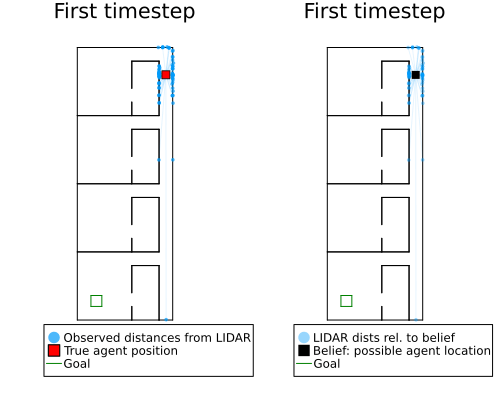

In [587]:
trace_to_gif(rollout_tr, title="First timestep")

In [588]:
rollout_tr, _ = Gen.update(rollout_tr,  # Update the record of the rollout...
    (200, PARAMS),                                          # ...updating it to a rollout of 100 steps, with the same PARAMS as before...
    (UnknownChange(), NoChange()),                        # ...noting that the time argument changed, and the params didn't
                                                          #    (so Gen knows not to revisit every choice depending on PARAMS)...
    EmptyChoiceMap()                                      # Don't constrain any of the randomness in the roll-out.
                                                          # (In principle, we could use this last argument to constrain either environmental
                                                          # randomness, or random choices made by the controller in the roll-out.)
);

room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false)
upsizing... -- t = 16
room should be added...
object_is_in_room: true
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => true)
adding target object segments
room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false)
upsized.


room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false)
upsizing... -- t = 58
room should be added...
object_is_in_room: true
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => true)
adding target object segments
room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false)
upsized.


room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false)
upsizing... -- t = 100
room should be added...
object_is_in_room: true
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => true)
adding target object segments
room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false)
upsized.
not downsizing.  t = 101 ; maxw = 0.999471791328917
not downsizing.  t = 102 ; maxw = 0.9547902819412867
not downsizing.  t = 103 ; maxw = 0.6416009938912299
not downsizing.  t = 104 ; maxw = 0.6462049377977048


not downsizing.  t = 105 ; maxw = 0.7241082583173657
not downsizing.  t = 106 ; maxw = 0.5960127722638117
not downsizing.  t = 107 ; maxw = 0.7085172632016048
not downsizing.  t = 108 ; maxw = 0.9083997694042022
not downsizing.  t = 109 ; maxw = 0.9689044195239108
not downsizing.  t = 110 ; maxw = 0.610816482402806


room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0

, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false, (bl = [0, 0], wh = [4, 5]) => false)
upsizing... -- t = 162
room should be added...
object_is_in_room: true
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false, (bl = [0, 0], wh = [4, 5]) => true)
adding target object segments
room should be added...
object_is_in_room: false
newmap: PersistentArrayMap{Any, Any}((bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false, (bl = [0, 0], wh = [4, 5]) => false)
upsized.
adding target object segments
adding target object segments
not downsizing.  t = 163 ; maxw = 0.6938948276142017
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
add

adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments


adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments
adding target object segments


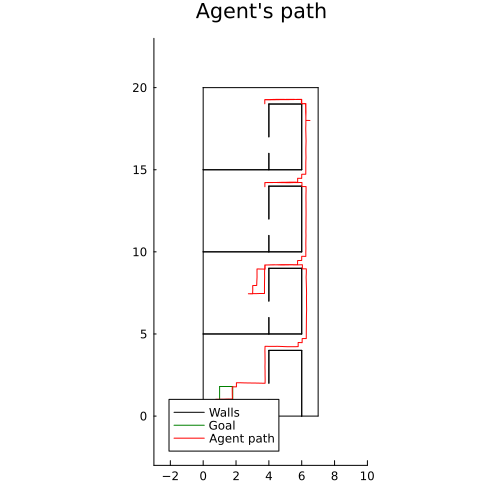

In [589]:
# Visualize the path the agent took.
trace_to_path_image(rollout_tr)

┌ Info: Saved animation to /tmp/jl_gnElaJSPg1.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_gnElaJSPg1.gif")
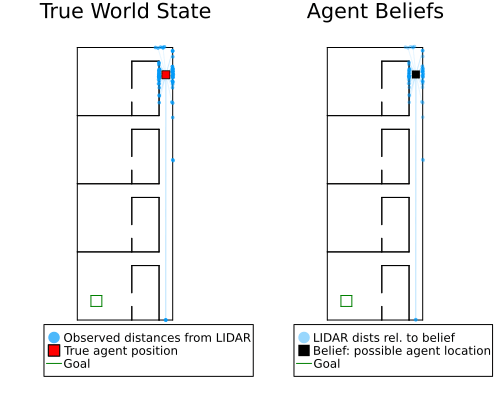

In [558]:
trace_to_gif(rollout_tr, fps=10)

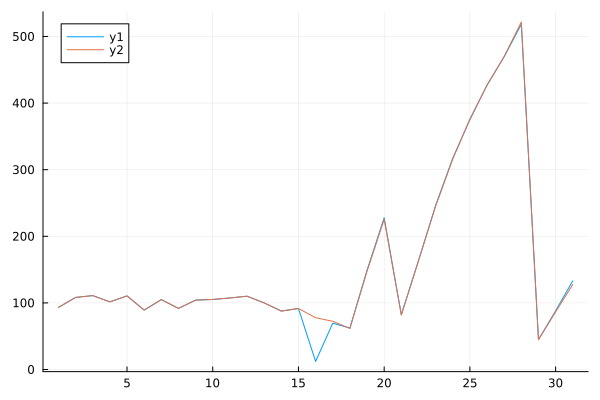

In [522]:
nparticles = [
    length(pf_state.traces) for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]
weights1 = [
    # GenParticleFilters.get_norm_weights(pf_state)[1]
    pf_state.log_weights[1]
    for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]
weights2 = [
    pf_state.log_weights[length(pf_state.traces) > 1 ? 2 : 1] 
    for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]

# plot(1:length(nparticles), nparticles)
plot(1:length(weights1), weights1)
plot!(1:length(weights2), weights2)

In [388]:
maximum(nparticles)

2

In [526]:
(_, (pf_state, _, _)) = GenPOMDPs.control_sequence(rollout_tr)[16];
GenPOMDPs.state_sequence(pf_state.traces[1])[end][2]

Persistent{Any, Any}Pair{Any, Any}[(bl = [0, 15], wh = [4, 5]) => true]

In [360]:
GenPOMDPs.state_sequence(pf_state.traces[2])[end][2]

Persistent{Any, Any}Pair{Any, Any}[(bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false]

┌ Info: Saved animation to /tmp/jl_GhO1Wd8Z8L.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_GhO1Wd8Z8L.gif")
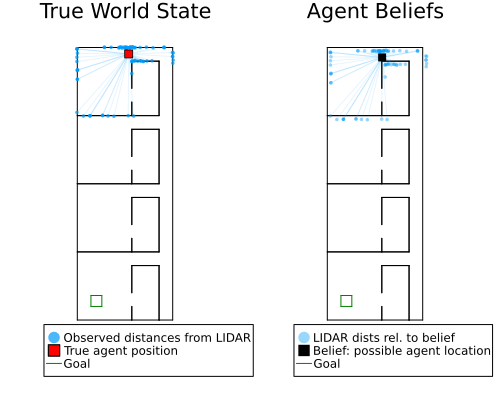

In [363]:
trace_to_gif(rollout_tr, 17, 17, fps=10)

In [283]:
(_, (pf_state, _, _)) = GenPOMDPs.control_sequence(rollout_tr)[argmax(nparticles)];
s = get_selected(get_choices(pf_state.traces[1]), select((state_addr(t, :extended_placements) for t=1:100)...))
display(s)

In [165]:
state_addr(1, :extend_placements)

:steps => (1 => (:state => :extend_placements))

In [350]:
params.rooms

UndefVarError: UndefVarError: params not defined

In [516]:
GenParticleFilters.pf_resize!

pf_resize! (generic function with 2 methods)